#**Complete Pipeline**

---

1. Read datasets
2. Drop columns with too many NaN's and object variables 
3. Treat resting NaNs 
4. Get Dummies
5. Standardize DataFrame
6. PCA
7. Determine n_clusters
8. Run Pipeline 
>1. Apply MiniBatchKMeans with n=30
>2. Filter for shared clusters between Portfolio and Market
>3. Calculate cosine similarity between 80% of the portfolio and the filtered market share
>4. Return the first k number of recommendations based on the highest cosine similarity score
9. Check the average precision score


### Reading the datasets and importing basic libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics.pairwise import cosine_similarity

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')
path_market = os.path.join('/content/gdrive/My Drive/datasets_codenation/',
                          'estaticos_market.csv')
path_portfolio1 = os.path.join('/content/gdrive/My Drive/datasets_codenation/',
                          'estaticos_portfolio1.csv')
path_portfolio2 = os.path.join('/content/gdrive/My Drive/datasets_codenation/',
                          'estaticos_portfolio2.csv')
path_portfolio3 = os.path.join('/content/gdrive/My Drive/datasets_codenation/',
                          'estaticos_portfolio3.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [0]:
df_market = pd.read_csv(path_market, index_col=0)
df_portfolio1 = pd.read_csv(path_portfolio1, usecols=['id'])
df_portfolio2 = pd.read_csv(path_portfolio2, index_col=0)
df_portfolio3 = pd.read_csv(path_portfolio3, index_col=0)

### Treating NaN's and Standardization

In [0]:
# Apply threshold for dropping NaNs with more than 60%

removed_columns = []
null_count = df_market.isna().sum()
percent = null_count/df_market.shape[0]
for col in df_market.iloc[:, 1:]:
    if df_market[col].isna().sum()/df_market[col].shape[0] > 0.6:
        removed_columns.append(col)

new_columns = list(set(df_market.columns) - set(removed_columns))
df_market = df_market.loc[:, new_columns]

In [0]:
# Splitting between ID and variables
df_id = df_market['id']
df_dummy = df_market.drop('id',axis=1)

In [0]:
# Fix True/False objects
df_dummy['fl_passivel_iss'] = df_dummy['fl_passivel_iss'].astype('bool')
df_dummy['fl_antt'] = df_dummy['fl_antt'].astype('bool')
df_dummy['fl_spa'] = df_dummy['fl_spa'].astype('bool')
df_dummy['fl_simples_irregular'] = df_dummy['fl_simples_irregular'].astype('bool')
df_dummy['fl_veiculo'] = df_dummy['fl_veiculo'].astype('bool')

In [0]:
# Filling NaNs in the rest of the Dataset

df_dummy['empsetorcensitariofaixarendapopulacao'] = df_dummy['empsetorcensitariofaixarendapopulacao'].fillna(
    df_dummy['empsetorcensitariofaixarendapopulacao'].mean()) # oreenchendo com a media
df_dummy['sg_uf_matriz'] = df_dummy['sg_uf_matriz'].fillna('outro')
df_dummy['qt_socios_st_regular'] = df_dummy['qt_socios_st_regular'].fillna(
    df_dummy['qt_socios_st_regular'].mean()) 
df_dummy['empsetorcensitariofaixarendapopulacao'] = df_dummy['empsetorcensitariofaixarendapopulacao'].fillna(
    df_dummy['empsetorcensitariofaixarendapopulacao'].median())
df_dummy['nm_divisao'] = df_dummy['nm_divisao'].fillna('COMERCIO VAREJISTA')
df_dummy['vl_total_veiculos_leves_grupo'] = df_dummy['vl_total_veiculos_leves_grupo'].fillna(0)
df_dummy['vl_faturamento_estimado_aux'] = df_dummy['vl_faturamento_estimado_aux'].fillna(
    df_dummy['vl_faturamento_estimado_aux'].median())
df_dummy['idade_minima_socios'] = df_dummy['idade_minima_socios'].fillna(
    df_dummy['idade_minima_socios'].mean())
df_dummy['fl_optante_simples'] = df_dummy['fl_optante_simples'].fillna(True) # possui 20mil leituras a mais, o que pode ser uma fonte de erro
df_dummy['nm_segmento'] = df_dummy['nm_segmento'].fillna('OUTRAS ATIVIDADES DE SERVICOS')
df_dummy['qt_socios_pj'] = df_dummy['qt_socios_pj'].fillna(0) 
df_dummy['nm_meso_regiao'] = df_dummy['nm_meso_regiao'].fillna('OUTRO') 
df_dummy['fl_optante_simei'] = df_dummy['fl_optante_simei'].fillna(True) # maioria
df_dummy['vl_faturamento_estimado_grupo_aux'] = df_dummy['vl_faturamento_estimado_grupo_aux'].fillna(
    df_dummy['vl_faturamento_estimado_grupo_aux'].mean()) # distribuição com muita assimetria
df_dummy['de_saude_tributaria'] = df_dummy['de_saude_tributaria'].fillna('VERDE') # assume-se que, ao nao preencher, esta no verde
df_dummy['de_saude_rescencia'] = df_dummy['de_saude_rescencia'].fillna('ACIMA DE 1 ANO')
df_dummy['idade_maxima_socios'] = df_dummy['idade_maxima_socios'].fillna(df_dummy['idade_maxima_socios'].mean())
df_dummy['vl_total_veiculos_pesados_grupo'] = df_dummy['vl_total_veiculos_pesados_grupo'].fillna(0) 
df_dummy['qt_socios_pf'] = df_dummy['qt_socios_pf'].fillna(df_dummy['qt_socios_pf'].median())
df_dummy['qt_socios_masculino'] = df_dummy['qt_socios_masculino'].fillna(
    df_dummy['qt_socios_masculino'].median()) # talvez preencher com 0 seja melhor
df_dummy['qt_socios'] = df_dummy['qt_socios'].fillna(
    df_dummy['qt_socios'].median())
df_dummy['de_faixa_faturamento_estimado'] = df_dummy['de_faixa_faturamento_estimado'].fillna(
    'DE R$ 81.000,01 A R$ 360.000,00')
df_dummy['nm_micro_regiao'] = df_dummy['nm_micro_regiao'].fillna('NAO ESPECIFICADO')
df_dummy['idade_media_socios'] = df_dummy['idade_media_socios'].fillna(df_dummy['idade_media_socios'].median())
df_dummy['setor'] = df_dummy['setor'].fillna('COMERCIO')
df_dummy['nu_meses_rescencia'] = df_dummy['nu_meses_rescencia'].fillna(df_dummy['nu_meses_rescencia'].mean())
df_dummy['de_faixa_faturamento_estimado_grupo'] = df_dummy['de_faixa_faturamento_estimado_grupo'].fillna(
    'DE R$ 81.000,01 A R$ 360.000,00')
df_dummy['de_nivel_atividade'] = df_dummy['de_nivel_atividade'].fillna('MEDIA')
df_dummy['dt_situacao'] = df_dummy['dt_situacao'].fillna('2005-11-03')

In [0]:
# Define a "dummyfied" DataFrame without object columns with too many readings - "macro" approach

df_new = pd.get_dummies(df_dummy.drop(['nm_micro_regiao','dt_situacao','de_natureza_juridica',
                                       'de_ramo','nm_meso_regiao','nm_divisao'],
                                      axis=1),sparse=True,drop_first=True)

In [0]:
# Standardize all values in the dataset (mean=0, std=1)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_scaled = scaler.fit_transform(df_new)

In [52]:
df_scaled.shape

(462298, 133)

### Principal component analysis

In [0]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(df_scaled)
ratio = pca.explained_variance_ratio_

In [0]:
counter = 0
value = 0

while value <= 0.60:
  value = np.cumsum(ratio)[counter]
  counter += 1
num_components = int(counter)

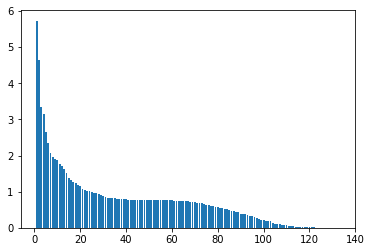

In [57]:
per_var = ratio*100
plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.show()

In [0]:
df_reduced = pd.DataFrame(PCA(n_components=num_components).fit_transform(df_scaled))

### Determine number of clusters

In [0]:
from sklearn.cluster import MiniBatchKMeans

# Define function to evaluate through the elbow method the optimal number of clusters

def mini_kmeans_elbow(number_of_clusters, data):
    model = MiniBatchKMeans(n_clusters = number_of_clusters, batch_size=500)
    model.fit(data)
    return [number_of_clusters, model.inertia_]

In [0]:
first_approach = []
for i in range(1,75):
    first_approach.append(mini_kmeans_elbow(i, df_reduced))
sns.lineplot(x=pd.DataFrame(first_approach)[0],
             y=pd.DataFrame(first_approach)[1])

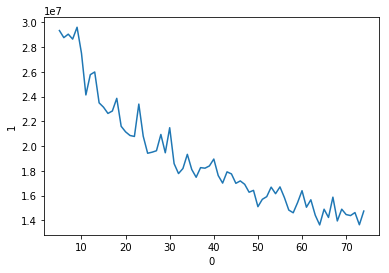

In [0]:
sns.lineplot(x=pd.DataFrame(first_approach)[0],
             y=pd.DataFrame(first_approach)[1])

In [0]:
from sklearn.cluster import KMeans

def kmeans_elbow(number_of_clusters, data):
    model = KMeans(n_clusters = number_of_clusters, n_jobs=6)
    model.fit(data)
    return [number_of_clusters, model.inertia_]

#second_approach = []
for i in range(40,60):
    second_approach.append(kmeans_elbow(i, df_reduced))


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be 

KeyboardInterrupt: ignored

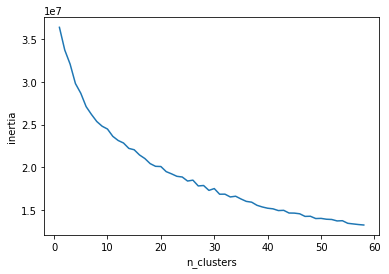

In [0]:
elbow_check = pd.DataFrame({'n_clusters':np.array(second_approach)[:,0],
                            'inertia':np.array(second_approach)[:,1]})

sns.lineplot(x='n_clusters',
             y='inertia',
            data=elbow_check)

In [0]:
for i in range(len(elbow_check)-1):
  print(round((elbow_check['inertia'][i+1]-elbow_check['inertia'][i])/elbow_check['inertia'][i]*100,2),i+1)

-7.3 1
-4.87 2
-7.1 3
-3.8 4
-5.45 5
-3.38 6
-3.16 7
-2.17 8
-1.33 9
-3.49 10
-2.05 11
-1.27 12
-2.76 13
-0.72 14
-2.76 15
-1.95 16
-2.84 17
-1.54 18
-0.12 19
-2.98 20
-1.32 21
-1.5 22
-0.43 23
-2.5 24
0.56 25
-3.66 26
0.28 27
-3.2 28
1.24 29
-3.77 30
0.03 31
-1.93 32
0.51 33
-1.93 34
-1.73 35
-0.58 36
-2.29 37
-1.26 38
-0.95 39
-0.47 40
-1.34 41
0.19 42
-2.1 43
-0.08 44
-0.53 45
-2.1 46
0.12 47
-1.87 48
0.13 49
-0.71 50
-0.21 51
-1.22 52
0.18 53
-2.19 54
-0.54 55
-0.54 56
-0.42 57


### Pipeline with n_clusters = 30

In [186]:
# KERNEL CRASHING WHEN SPECIFYING N_COMP = 30!  

from sklearn.mixture import BayesianGaussianMixture
import time
start_time = time.time()
def bayesiangm(data):
  bgm = BayesianGaussianMixture(n_components=10)
  b_labels = bgm.fit_predict(data)
  return b_labels  

b_labels = bayesiangm(df_reduced)
elapsed_time = time.time() - start_time
elapsed_time
 

/usr/local/lib/python3.6/dist-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


558.0606319904327

In [187]:
pd.DataFrame(b_labels).nunique()

0    10
dtype: int64

In [59]:
import time
from sklearn.cluster import MiniBatchKMeans
start_time = time.time()
def mini_kmeans(number_of_clusters, data):
    model = MiniBatchKMeans(n_clusters = number_of_clusters, batch_size=500)
    labels = model.fit_predict(data)
    distance = model.transform(data)
    return labels, distance
mk_labels, mk_distance = mini_kmeans(30,df_reduced)

elapsed_time = time.time() - start_time
elapsed_time

1.3410942554473877

In [0]:
df_reduced['labels'] = mk_labels

In [61]:
df_reduced['labels'].value_counts()

3     39048
2     33047
15    29632
9     28926
0     26965
11    26780
28    24207
10    23343
1     21806
25    21197
20    21194
19    20502
12    19189
24    16726
26    14451
16    13939
7     13211
13    12503
17    11804
8     10595
14     9677
18     5445
4      4347
22     3954
23     3189
21     2061
6      1927
27     1696
5       511
29      426
Name: labels, dtype: int64

In [0]:
X = pd.concat([df_id,df_reduced], axis='columns')

In [177]:
# portfolio 1 information

pf1_filled = X[X['id'].isin(df_portfolio1['id'].values)]

# part of the market that shares the same clusters
pf1_out = X.loc[X['labels'].isin(list(pf1_filled['labels'].unique()))]

# customer that are not yet on the company's portfolio
sample = pf1_filled.sample(frac=0.8, random_state=42)

pf1_rec = pf1_out.loc[~pf1_out['id'].isin(sample['id'])]

cosine_sim = cosine_similarity(pf1_rec.drop(['id'],axis='columns'),sample.drop(['id'],axis='columns'))
cosine_sim = np.amax(cosine_sim, axis=1)

pf1_rec['score'] = cosine_sim

# list of new leads to recommend

new_leads = 10000

recommendations = pd.DataFrame((pf1_rec.sort_values('score', ascending=False)[:new_leads])['id'])

(recommendations['id'].isin(pf1_filled['id'])*1).sum() / (len(pf1_filled)-len(sample)) *100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


5

In [178]:
# portfolio 2 information

pf2_filled = X[X['id'].isin(df_portfolio2['id'].values)]

# part of the market that shares the same clusters
pf2_out = X.loc[X['labels'].isin(list(pf2_filled['labels'].unique()))]

# customer that are not yet on the company's portfolio
sample2 = pf2_filled.sample(frac=0.8, random_state=42)


pf2_rec = pf2_out.loc[~pf2_out['id'].isin(sample2['id'])]

cosine_sim = cosine_similarity(pf2_rec.drop(['id'],axis='columns'),sample2.drop(['id'],axis='columns'))
cosine_sim = np.amax(cosine_sim, axis=1)

pf2_rec['score'] = cosine_sim

# list of new leads to recommend

new_leads = 1000

recommendations2 = pd.DataFrame((pf2_rec.sort_values('score', ascending=False)[:new_leads])['id'])

(recommendations2['id'].isin(pf2_filled['id'])*1).sum() / (len(pf2_filled)-len(sample2)) *100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


74.33628318584071

In [179]:
# portfolio 3 information

pf3_filled = X[X['id'].isin(df_portfolio3['id'].values)]

# part of the market that shares the same clusters
pf3_out = X.loc[X['labels'].isin(list(pf3_filled['labels'].unique()))]

# customer that are not yet on the company's portfolio
sample3 = pf3_filled.sample(frac=0.8, random_state=42)


pf3_rec = pf3_out.loc[~pf3_out['id'].isin(sample3['id'])]

cosine_sim = cosine_similarity(pf3_rec.drop(['id'],axis='columns'),sample3.drop(['id'],axis='columns'))
cosine_sim = np.amax(cosine_sim, axis=1)

pf3_rec['score'] = cosine_sim

# list of new leads to recommend

new_leads = 1000

recommendations3 = pd.DataFrame((pf3_rec.sort_values('score', ascending=False)[:new_leads])['id'])

(recommendations3['id'].isin(pf3_filled['id'])*1).sum() / (len(pf3_filled)-len(sample3)) *100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


86.79245283018868

### Average Precision Evaluation

In [0]:
def custom_apk(market_list, test_list, k):
    
    '''Custom function for the average precision at k - AP@k

    market_list: list of ids from all the recommended companies sorted by descending score (order does matter)

    test_list: list of ids from all companies in the ~20% test dataframe (order does not matter)

    k: number of recommendations'''

    if len(market_list) > k:
        market_list = market_list[:k]
    
    score = 0.0
    num_hits = 0.0
  
    for i, p in enumerate(market_list):
        if p in test_list:
          num_hits += 1.0
          score += num_hits / (i + 1.0)

    return score / len(test_list)

In [0]:
market1 = list(pf1_rec.sort_values('score', ascending=False)['id'])
test1 = list(pf1_filled.loc[~pf1_filled['id'].isin(sample['id'])]['id'])

onek, fivek, tenk = custom_apk(market1, test1, 1000),custom_apk(market1, test1, 5000),custom_apk(market1, test1, 10000)

market2 = list(pf2_rec.sort_values('score', ascending=False)['id'])
test2 = list(pf2_filled.loc[~pf2_filled['id'].isin(sample2['id'])]['id'])

onek2, fivek2, tenk2 = custom_apk(market2, test2, 1000),custom_apk(market2, test2, 5000),custom_apk(market2, test2, 10000)

market3 = list(pf3_rec.sort_values('score', ascending=False)['id'])
test3 = list(pf3_filled.loc[~pf3_filled['id'].isin(sample3['id'])]['id'])

onek3, fivek3, tenk3 = custom_apk(market3, test3, 1000),custom_apk(market3, test3, 5000),custom_apk(market3, test3, 10000)

In [182]:
print('Portfólio #1')
print(' ')
print(f'AP@1k: {onek}')
print(f'AP@5k: {fivek}')
print(f'AP@10k: {tenk}')
print(' ')
print('Portfólio #2')
print(' ')
print(f'AP@1k: {onek2}')
print(f'AP@5k: {fivek2}')
print(f'AP@10k: {tenk2}')
print(' ')
print('Portfólio #3')
print(' ')
print(f'AP@1k: {onek3}')
print(f'AP@5k: {fivek3}')
print(f'AP@10k: {tenk3}')

Portfólio #1
 
AP@1k: 2.160433815110074e-05
AP@5k: 2.5402402657428316e-05
AP@10k: 4.0453723023843515e-05
 
Portfólio #2
 
AP@1k: 0.08787222083910907
AP@5k: 0.10726233587905107
AP@10k: 0.10726233587905107
 
Portfólio #3
 
AP@1k: 0.09766933499622962
AP@5k: 0.10169745930264222
AP@10k: 0.10169745930264222
